# LogisticRegression

In [1]:
from __future__ import division
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os, re


from sklearn.linear_model     import LogisticRegression

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV
from sklearn.cross_validation import cross_val_predict, permutation_test_score

In [2]:
SEED   = 1091
scale  = False 
minmax = False
normd   = False
nointercept = True
engineering = True

N_CLASSES = 2

submission_filename = "../submissions/submission_LogisticRegressionSEED1091.csv"

# Load the training data

In [3]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = normd,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Fit the model

In [4]:
StatifiedCV = StratifiedKFold(y            = y_train, 
                              n_folds      = 10, 
                              shuffle      = True, 
                              random_state = SEED)

In [5]:
%%time

random.seed(SEED)

clf = LogisticRegression(penalty           = 'l2',          #  'l1', 'l2'
                         dual              = False, 
                         C                 = 1.0, 
                         fit_intercept     = True,
                         solver            = 'liblinear',   # 'newton-cg', 'lbfgs', 'liblinear', 'sag' 
                         max_iter          = 100, 
                         intercept_scaling = 1,
                         
                         tol               = 0.0001, 
                         class_weight      = None, 
                         random_state      = SEED, 
                         multi_class       = 'ovr', 
                         verbose           = 0, 
                         warm_start        = False, 
                         n_jobs            = -1)



# param_grid = dict(C             = [0.0001, 0.001, 0.01, 0.1],
#                   fit_intercept = [True, False],
#                   penalty       = ['l1', 'l2'],
#                   #solver        = ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
#                   max_iter      = [50, 100, 250])

# grid_clf = GridSearchCV(estimator  = clf, 
#                         param_grid = param_grid,
#                         n_jobs     = 1,  
#                         cv         = StatifiedCV).fit(X_train, y_train)

# print("clf_params = {}".format(grid_clf.best_params_))
# print("score: {}".format(grid_clf.best_score_))

# clf = grid_clf.best_estimator_




clf_params = {'penalty': 'l2', 'C': 0.001, 'max_iter': 50, 'fit_intercept': True}
clf.set_params(**clf_params)
clf.fit(X_train, y_train)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.34 ms


In [6]:
# from sklearn_utilities import GridSearchHeatmap

# GridSearchHeatmap(grid_clf, y_key='learning_rate', x_key='n_estimators')

# from sklearn_utilities import plot_validation_curves

# plot_validation_curves(grid_clf, param_grid, X_train, y_train, ylim = (0.0, 1.05))

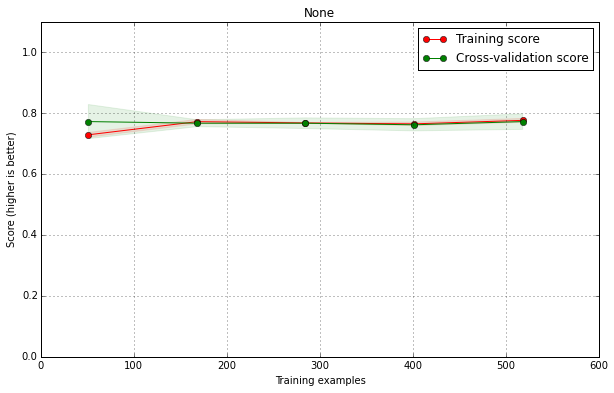

CPU times: user 216 ms, sys: 36 ms, total: 252 ms
Wall time: 403 ms


In [7]:
%%time

try:
    from sklearn_utilities import plot_learning_curve
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_learning_curve

plot_learning_curve(estimator   = clf, 
                    title       = None, 
                    X           = X_train, 
                    y           = y_train, 
                    ylim        = (0.0, 1.10), 
                    cv          = 10, 
                    train_sizes = np.linspace(.1, 1.0, 5),
                    n_jobs      = -1)

plt.show()

# Training set predictions

In [8]:
%%time

train_preds = cross_val_predict(estimator    = clf, 
                                X            = X_train, 
                                y            = y_train, 
                                cv           = StatifiedCV, 
                                n_jobs       = -1, 
                                verbose      = 0, 
                                fit_params   = None, 
                                pre_dispatch = '2*n_jobs')

y_true, y_pred   = y_train, train_preds

CPU times: user 56 ms, sys: 16 ms, total: 72 ms
Wall time: 177 ms


[[424  14]
 [116  22]]


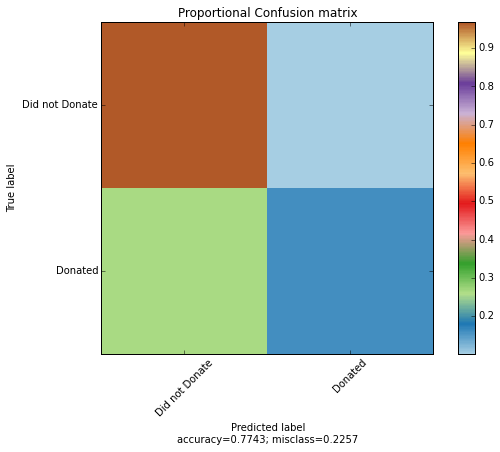

Accuracy 0.7743, mis-class rate 0.2257


In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix

plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy,misclass))

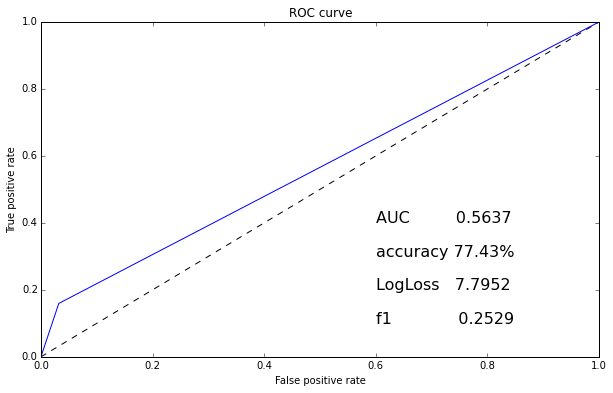

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

AUC = roc_auc_score(y_true, y_pred, average='macro')
plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(AUC),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

logloss = log_loss(y_true, y_pred)
plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(logloss),
        fontsize=16)

f1 = f1_score(y_true, y_pred)
plt.text(x=0.6,y=0.1,s="f1             {:.4f}"\
         .format(f1),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

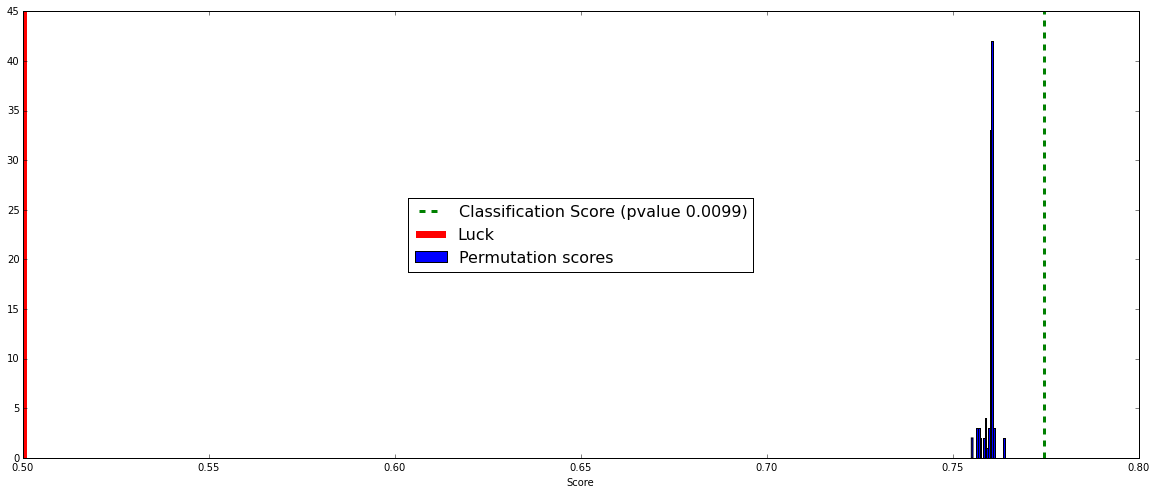

CPU times: user 396 ms, sys: 52 ms, total: 448 ms
Wall time: 814 ms


In [11]:
%%time

score, permutation_scores, pvalue = permutation_test_score(estimator      = clf, 
                                                           X              = X_train.values.astype(np.float32), 
                                                           y              = y_train, 
                                                           cv             = StatifiedCV, 
                                                           labels         = None,
                                                           random_state   = SEED,
                                                           verbose        = 0,
                                                           n_permutations = 100, 
                                                           scoring        = None,
                                                           n_jobs         = -1) 

plt.figure(figsize=(20,8))
plt.hist(permutation_scores, 20, label='Permutation scores')

ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score (pvalue {:.4f})'.format(pvalue))
         
plt.plot(2 * [1. / N_CLASSES], ylim, 'r', linewidth=7, label='Luck')

plt.ylim(ylim)
plt.legend(loc='center',fontsize=16)
plt.xlabel('Score')
plt.show()

# find mean and stdev of the scores
from scipy.stats import norm
mu, std = norm.fit(permutation_scores)

In [12]:
# format for scores.csv file
import re
algo = re.search(r"submission_(.*?)\.csv", submission_filename).group(1)
print("{: <26} ,        ,   {:.4f} ,  {:.4f} , {:.4f} , {:.4f} , {:.4f} , {:.4f}"\
      .format(algo,accuracy,logloss,AUC,f1,mu,std))

LogisticRegressionSEED1091 ,        ,   0.7743 ,  7.7952 , 0.5637 , 0.2529 , 0.7600 , 0.0013


# Predict leaderboard score with linear regression

In [13]:
# load the R extension
%load_ext rpy2.ipython

# see http://ipython.readthedocs.org/en/stable/config/extensions/index.html?highlight=rmagic
# see http://rpy.sourceforge.net/rpy2/doc-2.4/html/interactive.html#module-rpy2.ipython.rmagic

clear all but functions rm(list = setdiff(ls(), lsf.str()))
R functions in Dropbox:
 [1] "confusion.matrix_ROC.R" "eda.R"                  "knitr_settings.R"      
 [4] "lm_utilities.R"         "lsp.R"                  "matrix.power.R"        
 [7] "metrics.R"              "multiplot.R"            "my.special.functions.R"
[10] "NOT_IN.R"               "SDAFE.R"                "signOnToTwitter.R"     
[13] "source.dropbox.R"       "stem_plot.R"           
to load these functions: source("/home/george/Dropbox/R_functions/*.R")

To save graphical parameters: opar = par(no.readonly=TRUE)
to restore graphical parameters: par(opar)


In [14]:
# Import python variables into R
%R -i accuracy,logloss,AUC,f1,mu,std

In [15]:
%%R
# read in the scores.csv file and perform a linear regression with it using this process's variables

score_data = read.csv('../input/scores.csv')

lm.fit     = lm(leaderboard_score ~ accuracy + logloss + AUC + f1 + mu + std, 
                data      = score_data, 
                na.action = na.omit)

slm.fit = step(lm.fit, direction = "both", trace=0)

predicted_leaderboard_score = predict(object   = slm.fit, 
                                      newdata  = data.frame(accuracy,logloss,AUC,f1,mu,std),
                                      interval = "prediction", level = 0.99)

print(round(predicted_leaderboard_score,4))

     fit    lwr    upr
1 0.4935 0.0358 0.9512


# --------------------------------------------------------------------------------------------

# Test Set Predictions

## Re-fit with the full training set

In [16]:
clf.set_params(**clf_params)
clf.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=1091, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Load the test data

In [17]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = normd,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the fitted model

In [18]:
y_pred = clf.predict(X_test)
print(y_pred[:10])

try:
    y_pred_probs  = clf.predict_proba(X_test)
    print(y_pred_probs[:10])
    donate_probs  = [prob[1] for prob in y_pred_probs]
except Exception,e:
    print(e)
    donate_probs = [0.65 if x>0 else 1-0.65 for x in y_pred]
    
print(donate_probs[:10])

[0 0 0 0 1 1 0 0 0 0]
[[ 0.52391319  0.47608681]
 [ 0.87801333  0.12198667]
 [ 0.75376222  0.24623778]
 [ 0.6585946   0.3414054 ]
 [ 0.46953723  0.53046277]
 [ 0.26572181  0.73427819]
 [ 0.71737399  0.28262601]
 [ 0.85620701  0.14379299]
 [ 0.99785974  0.00214026]
 [ 0.94865091  0.05134909]]
[0.47608681478511899, 0.12198667376092551, 0.24623778111483186, 0.34140540251126056, 0.53046276534857573, 0.7342781930436989, 0.28262601292104306, 0.14379298665066198, 0.0021402576206707878, 0.051349092332859211]


# Create the submission file

In [19]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()